In [1]:
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.shape

(568454, 10)

## Limiting the data for faster processing

In [4]:
df = df.head(800)
df.shape

(800, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      800 non-null    int64 
 1   ProductId               800 non-null    object
 2   UserId                  800 non-null    object
 3   ProfileName             800 non-null    object
 4   HelpfulnessNumerator    800 non-null    int64 
 5   HelpfulnessDenominator  800 non-null    int64 
 6   Score                   800 non-null    int64 
 7   Time                    800 non-null    int64 
 8   Summary                 800 non-null    object
 9   Text                    800 non-null    object
dtypes: int64(5), object(5)
memory usage: 62.6+ KB


In [6]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,800.0000,800.000000,800.000000,800.00000,8.000000e+02
mean,400.5000,1.211250,1.691250,4.18375,1.287489e+09
std,231.0844,2.784567,3.314311,1.33124,5.281042e+07
min,1.0000,0.000000,0.000000,1.00000,1.107821e+09
25%,200.7500,0.000000,0.000000,4.00000,1.247854e+09
50%,400.5000,0.000000,1.000000,5.00000,1.302221e+09
75%,600.2500,1.000000,2.000000,5.00000,1.332742e+09
max,800.0000,43.000000,47.000000,5.00000,1.351210e+09


In [7]:
# checking for missing values
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

there are no missing values in the selected data set

In [8]:
# checking for duplicates
df.duplicated().sum()

0

## Exploratory Data Analysis (EDA)

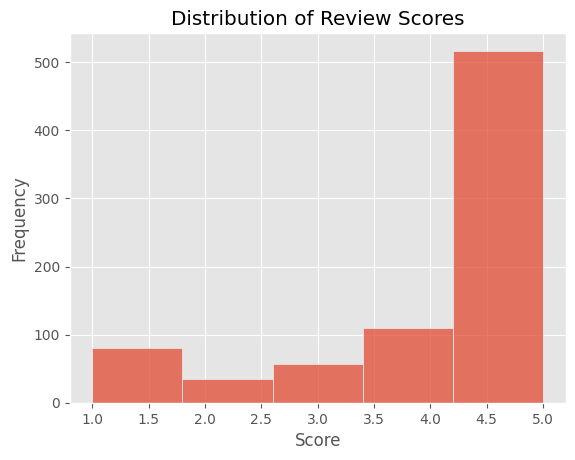

In [9]:
# distribution of review scores based on star rating
sns.histplot(df['Score'], bins=5, kde=False)
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [10]:
df1 = df
df1['HelpfulnessRatio'] = df['HelpfulnessNumerator']/df['HelpfulnessDenominator']
df1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,NaN


In [11]:
df1['HelpfulnessRatio'].replace([float('inf'), float('-inf')], None, inplace = True)

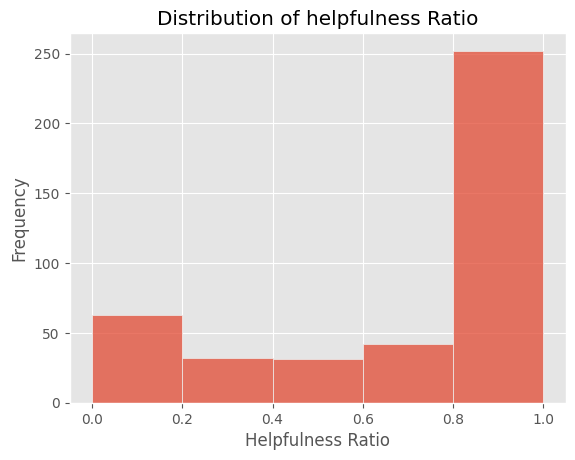

In [12]:
sns.histplot(df['HelpfulnessRatio'], bins = 5,kde = False)
plt.title('Distribution of helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Frequency')
plt.show()

## Santiment Analysis

### VADER Sentiment Analyzer (Valence Aware Dictionary and sEntiment Reasoner)

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer() # gives sentiment intersity score

In [14]:
# Running polarity score on dataset
res = {}
for i , row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text) 

  0%|          | 0/800 [00:00<?, ?it/s]

In [15]:
vaders = pd.DataFrame(res).T

In [16]:
vaders = vaders.reset_index().rename(columns = {'index' : 'Id'})
vaders = vaders.merge(df, how = 'left')

In [17]:
vaders.head(4)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0


Text(0.5, 1.0, 'Compound scores for amazon reviews')

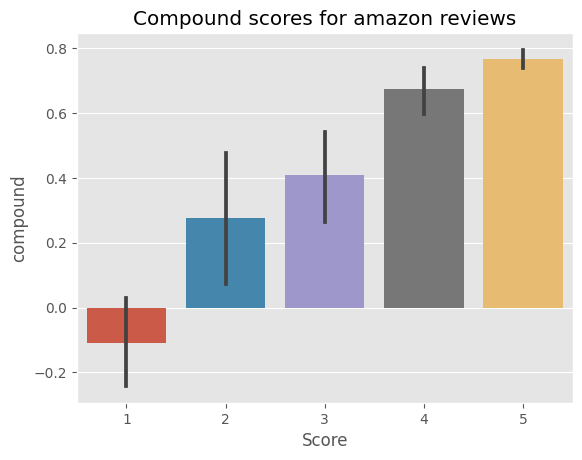

In [18]:
# visualizing vader results
sns.barplot(data = vaders, x = 'Score', y = 'compound')
plt.title("Compound scores for amazon reviews")

This indicates that most of the reviews are positive and with a high sentiment polarity in positivity while the negative reviews are few and have low sentiment polarity .

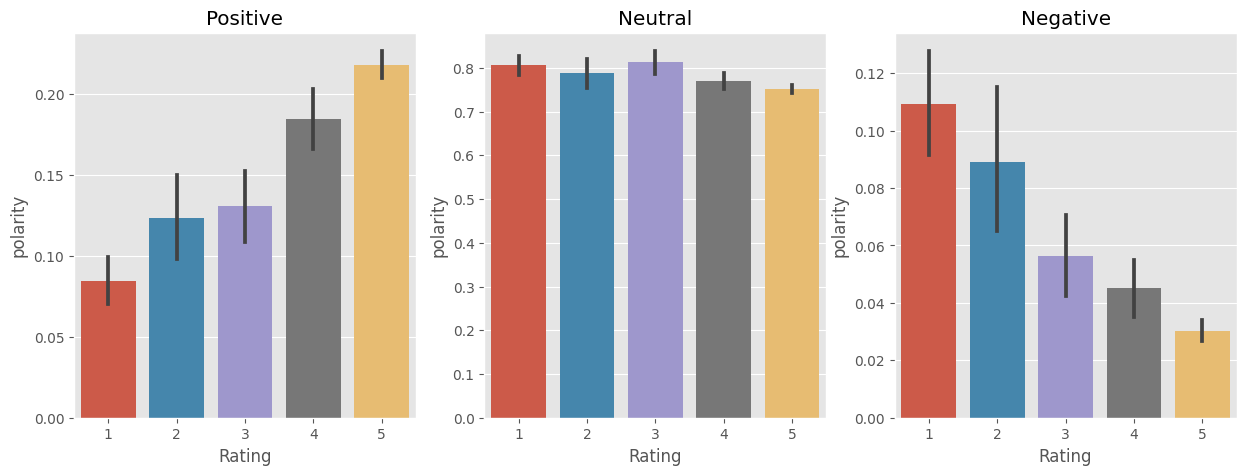

In [19]:
#Sub-plot for each category
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
sns.barplot(data = vaders, x = 'Score', y = 'pos', ax = axes[0])
axes[0].set_title('Positive')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('polarity')

sns.barplot(data = vaders, x = 'Score', y = 'neu', ax = axes[1])
axes[1].set_title('Neutral')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('polarity')

sns.barplot(data = vaders, x = 'Score', y = 'neg', ax = axes[2])
axes[2].set_title('Negative')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('polarity')

plt.show()

https://medium.com/@eulene/sentiment-analysis-of-amazon-reviews-using-natural-language-processing-6ecb3e253a5e

## Roberta Pre-trained Model

In [39]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [40]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


In [43]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors="pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores [0],
        'roberta_neu' : scores [1],
        'roberta_pos' : scores [2]
    }
    return (scores_dict)

In [45]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text =  row['Text']
        myid = row['Id']
        vader_res = sia.polarity_scores(text)
        vader_res_rename = {}
        for key, value in vader_res.items():
            vader_res_rename[f"vader_{key}"] = value
        roberta_res = polarity_scores_roberta(text)
        both = {**vader_res_rename, **roberta_res}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/800 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746


Overall, this code performs sentiment analysis on each review text in the DataFrame using both VADER and the RoBERTa model, and stores the results in a dictionary for further analysis.

In [47]:
#Create a data frame to plot the results
res_df = pd.DataFrame(res).T
res_df = res_df.reset_index().rename(columns = {"index":"Id"})
res_df = res_df.merge(df, how = 'left')
res_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,NaN


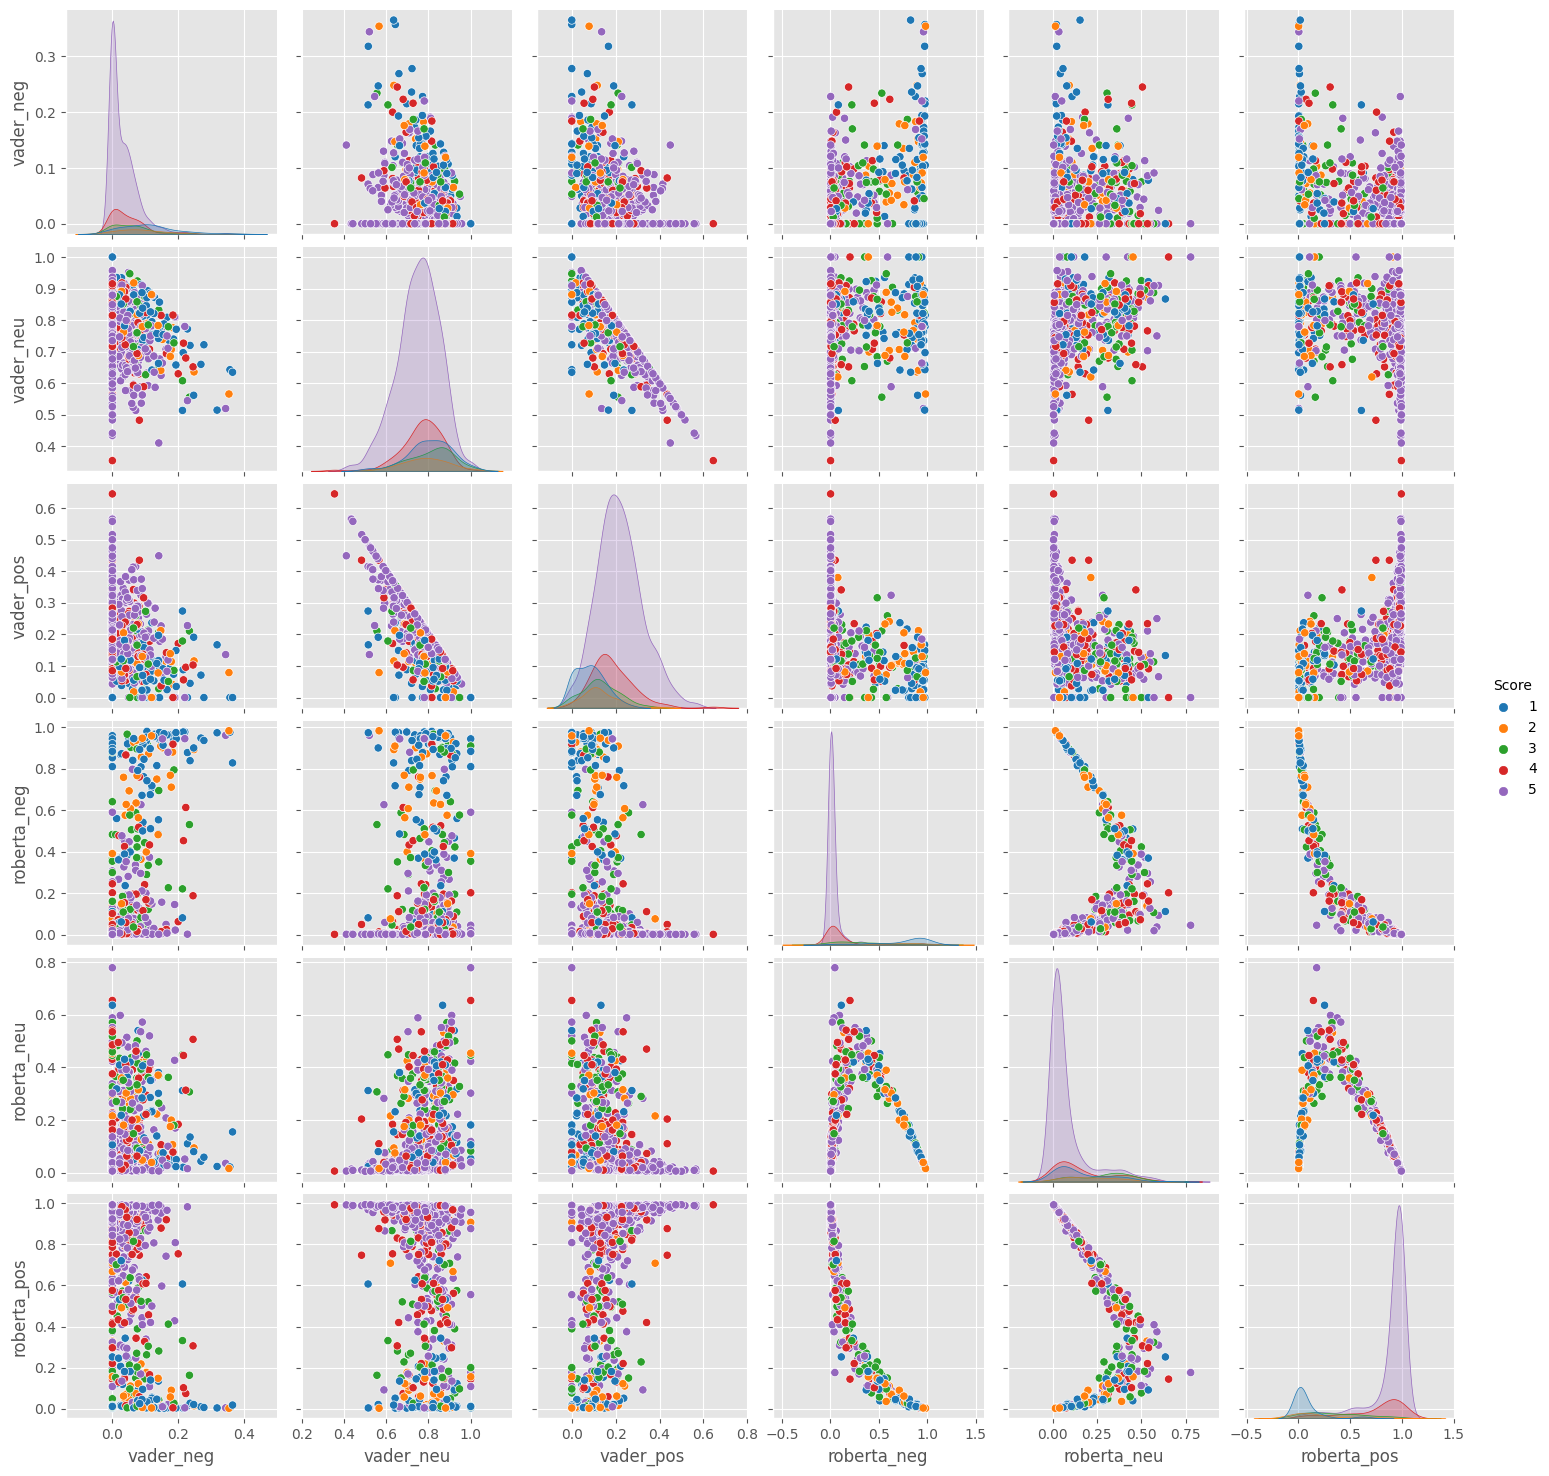

In [49]:
# comparision and evaluation
sns.pairplot (data = res_df, vars= ['vader_neg', 'vader_neu', 'vader_pos',
                    'roberta_neg', 'roberta_neu', 'roberta_pos'],
                    hue= 'Score', palette = 'tab10')
plt.show()

In [50]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [51]:
sent_pipeline ('I love dogs' )

[{'label': 'POSITIVE', 'score': 0.999713122844696}]

In [53]:
sent_pipeline('you are an idiot')

[{'label': 'NEGATIVE', 'score': 0.9997456669807434}]